In [2]:
import requests 
from urllib.parse import urlencode 
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('ggplot')
from scipy.stats import chi2_contingency
import datetime as dt

### Задание 1. A/B–тестирование

Считывание файла groups.csv с Яндекс Диск:

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
groups = pd.read_csv(download_url, sep=';') 
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.shape

(74484, 2)

In [5]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [6]:
groups.groupby('grp', as_index = False).agg({'id':'count'})

,grp,id
0,A,14671
1,B,59813


Контрольная и тестовая выборки распределены в пропорции 20% на 80% соотв.

Считывание файла group_add.csv с Яндекс Диск:

In [7]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
group_add = pd.read_csv(download_url, sep=',') 
group_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
group_add.shape

(92, 2)

In [9]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
group_add.groupby('grp', as_index = False).agg({'id':'count'})

,grp,id
0,A,22
1,B,70


Считывание файла active_studs.csv с Яндекс Диск:

In [11]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
active_studs = pd.read_csv(download_url, sep=',').rename(columns=({'student_id':'id'})) 
active_studs.head(5)

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.shape

(8341, 1)

In [13]:
active_studs.isna().sum()

id    0
dtype: int64

Считывание файла checks.csv с Яндекс Диск:

In [14]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
checks = pd.read_csv(download_url, sep=';').rename(columns=({'student_id':'id'})) 
checks.head(5)

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
checks.shape

(541, 2)

In [16]:
checks.isna().sum()

id     0
rev    0
dtype: int64

Рассмотрим следующие метрики:
    1. ARPU;
    2. ARPPU;
    3. Конверсия в покупку.  

Объеденим таблицы с информацией об принадлежности пользователя к какой-либо группе и оплате, при этом для дальнейшего рассмотрения оставим пользователей, зашедших на платформу в дни проведения эксперимента:

In [18]:
revenue_active = checks.merge(groups, on = 'id', how = 'outer').merge(active_studs, on = 'id')[['rev', 'grp']]
revenue_active.isna().sum()

rev    7937
grp       1
dtype: int64

Заменим NaN значения на нули:

In [19]:
revenue_active['rev'] = revenue_active['rev'].fillna(0)

Рассмотрим среднюю выручку (ARPU) пользователей, зашедших на сайт в дни проведения эксперимента:

In [20]:
revenue_group_active_dummy = pd.get_dummies(data=revenue_active[['rev', 'grp']], drop_first = True)
results = smf.ols('rev ~ grp_B', revenue_group_active_dummy).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    rev   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.109
Date:                Tue, 16 May 2023   Prob (F-statistic):              0.292
Time:                        20:41:27   Log-Likelihood:                -59593.
No. Observations:                8329   AIC:                         1.192e+05
Df Residuals:                    8327   BIC:                         1.192e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.6458      7.906      6.153      0.0

Средний чек группы А (контрольной) равен 48.65, тестовой 57,86. p_value равен 0,292 > 0,05, что говорит о незначительности влияния целевой группы относительно контрольной 

Посмотрим на распределения контрольной и тестовых групп, сделаем проверку нормальности распределений и гомогенности дисперсий:

In [21]:
revenue_a_active = revenue_group_active_dummy.query('grp_B == 0')['rev']
revenue_b_active = revenue_group_active_dummy.query('grp_B == 1')['rev']

In [22]:
print(revenue_a_active.shape[0])
print(revenue_b_active.shape[0])

1536
6793


Выборки распределены в пропорции 80% (тестовая) на 20%(контрольная) группы

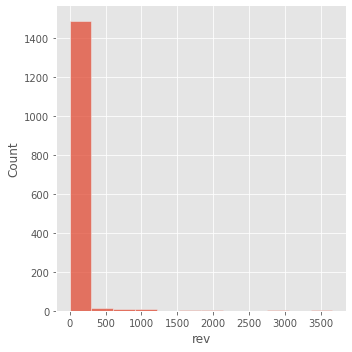

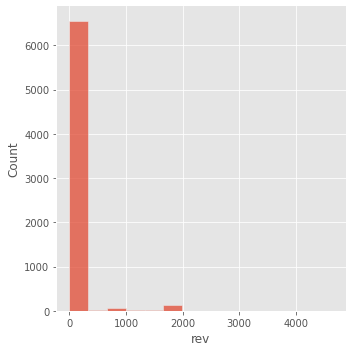

In [23]:
sns.displot(data = revenue_a_active)
sns.displot(data = revenue_b_active)

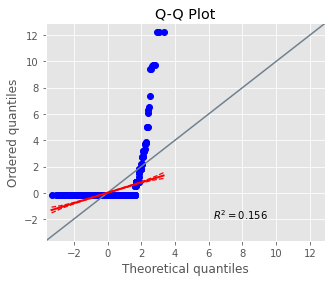

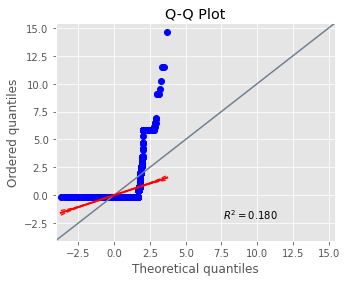

In [24]:
pg.qqplot(revenue_a_active)
pg.qqplot(revenue_b_active)

In [25]:
ss.levene(revenue_a_active, revenue_b_active)

LeveneResult(statistic=1.1090328101656157, pvalue=0.292322847749846)

По результату p_value теста Левена больше 0,05 - дисперсии гомогенны, распределения ненормальны

Проведем t-тест между тестовой и контрольной группами

In [26]:
print(ss.ttest_ind(revenue_b_active, revenue_a_active))

Ttest_indResult(statistic=1.0531062672710745, pvalue=0.2923228477488985)


ARPU в тестовой группе выше, чем в контрольной 48.65 и 57,86 соотв. Однако, по результату t-теста p_value большей порога значимости в 0.05, соотв. результат не имеет стат.значимости.

Рассмотрим ARPPU:

In [27]:
revenue_group_active_purchased_dummy = pd.get_dummies(data=revenue_active.query('rev > 0')[['rev', 'grp']], drop_first = True)
results = smf.ols('rev ~ grp_B', revenue_group_active_purchased_dummy).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    rev   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.043
Date:                Tue, 16 May 2023   Prob (F-statistic):            0.00281
Time:                        20:43:49   Log-Likelihood:                -3184.7
No. Observations:                 392   AIC:                             6373.
Df Residuals:                     390   BIC:                             6381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    945.8228     92.118     10.268      0.0

Посмотрим на распределения контрольной и тестовых групп, сделаем проверку нормальности распределений и гомогенности дисперсий:

In [28]:
revenue_active_a = revenue_group_active_purchased_dummy.query('grp_B == 0')['rev']
revenue_active_b = revenue_group_active_purchased_dummy.query('grp_B == 1')['rev']

In [29]:
print(revenue_active_a.shape[0])
print(revenue_active_b.shape[0])

79
313


Выборки распределены в пропорции 80% (тестовая) на 20%(контрольная) группы

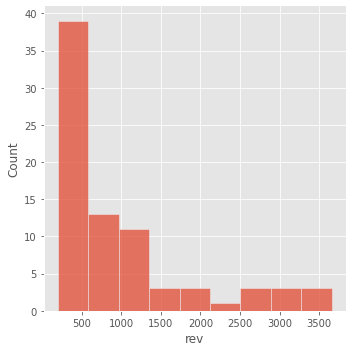

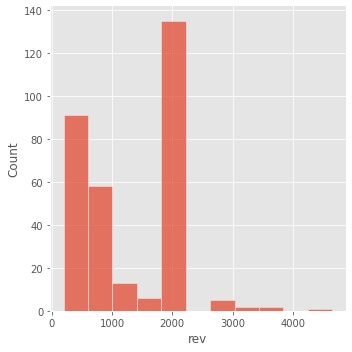

In [30]:
sns.displot(data = revenue_active_a)
sns.displot(data = revenue_active_b)

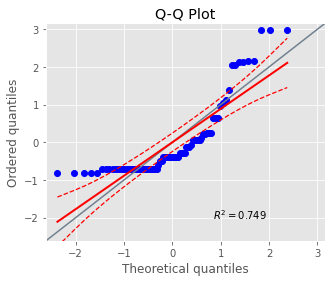

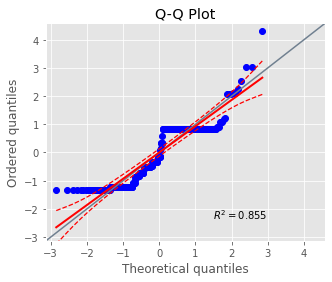

In [31]:
pg.qqplot(revenue_active_a)
pg.qqplot(revenue_active_b)

In [32]:
ss.levene(revenue_active_a, revenue_active_b)

LeveneResult(statistic=2.5886595228454956, pvalue=0.10844053291361465)

По результату p_value теста Левена больше 0,05 - дисперсии гомогенны, распределения ненормальны

Проведем t-тест между тестовой и контрольной группой:

In [33]:
print(ss.ttest_ind(revenue_active_b, revenue_active_a))

Ttest_indResult(statistic=3.0071494141957733, pvalue=0.00280790333544559)


In [34]:
print(revenue_active_b.mean())
print(revenue_active_a.mean())

1255.8274872204472
945.8227848101266


Значение ARPPU в тестовой группе 1255,83, а в контрольной 945,82. По результатам анализа получен положительный стат.значимый результат (t-тест).

Рассмотрим конверсию в покупку:

In [35]:
purchase_a_active = revenue_group_active_dummy.query('rev > 0 & grp_B == 0').shape[0]
not_purchase_a_active = revenue_group_active_dummy.query('grp_B == 0').shape[0] - purchase_a_active
purchase_b_active = revenue_group_active_dummy.query('rev > 0 & grp_B == 1').shape[0]
not_purchase_b_active = revenue_group_active_dummy.query('grp_B == 1').shape[0] - purchase_b_active
cr_active = np.array([[purchase_a_active, not_purchase_a_active], [purchase_b_active, not_purchase_b_active]])
cr_active

array([[  79, 1457],
       [ 313, 6480]])

Воспользуемся тестом Хи-квадрат:

In [36]:
res_pvalue = ss.chi2_contingency(cr_active)[1]
res_pvalue

0.4074752883572411

In [37]:
print(purchase_a_active / (purchase_a_active + not_purchase_a_active)*100)
print(purchase_b_active / (purchase_b_active + not_purchase_b_active)*100)

5.143229166666666
4.607684380980421


Конверсия в покупку стат.значимо не изменилась, в контрольной группе конверсия в покупку выше.

***Анализ полученных результатов позволил сделать следующие выводы***:
1. ARPU в тестовой группе выше, чем в контрольной 57,86 и 48,65 соотв. Однако, по результату t-теста p_value больше порога значимости в 0.05, соотв. принята нулевая гипотеза о равенстве средних;
2. Значение ARPPU в тестовой группе 1255,83, а в контрольной 945,82. По результатам анализа получен положительный стат.значимый результат по результатам t-теста, отвергаем нулевую гипотезу о равенстве средних;
3. Конверсия в покупку стат.значимо не изменилась, в контрольной группе конверсия в покупку выше.  
  
С учетом полученных результатов, новую механику оплаты на всех пользователей запускать *не рекомендуется*. Следует принять во внимание, что ARPPU тестовой группы оказался больше и стат.значим относительно контрольной группы.   

### Задача 2. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [38]:
"""Функция добавляет файл (group_add) к основному (groups), формирует выборки по выручке (checks) среди пользователей,
зашедших на платформу (active_studs) в дни проведения эксперимента
(аналогично задаче №1, представленной выше), после чего подсчитываются обновленные метрики arpu, arppu, cr.
По итогу результат возвращается в итоговой таблице (df)."""

def update_metric(groups, active_studs, checks, group_add):
    groups_update = pd.concat([groups, group_add])
    revenue_active_update = checks.merge(groups_update, on = 'id', how = 'outer').merge(active_studs, on = 'id')[['rev', 'grp']]
    revenue_active_update['rev'] = revenue_active['rev'].fillna(0)
    arpu_control_update = pd.get_dummies(data=revenue_active_update[['rev', 'grp']], drop_first = True)\
    .query('grp_B == 0')['rev'].mean().round(2)
    arpu_test_update =pd.get_dummies(data=revenue_active_update[['rev', 'grp']], drop_first = True)\
    .query('grp_B == 1')['rev'].mean().round(2)
    arppu_control_update = pd.get_dummies(data=revenue_active_update.query('rev > 0')[['rev', 'grp']], drop_first = True)\
    .query('grp_B == 0')['rev'].mean().round(2)
    arppu_test_update = pd.get_dummies(data=revenue_active_update.query('rev > 0')[['rev', 'grp']], drop_first = True)\
    .query('grp_B == 1')['rev'].mean().round(2)
    
    cr_control_update = (pd.get_dummies(data=revenue_active_update[['rev', 'grp']], drop_first = True)\
    .query('rev > 0 & grp_B == 0').shape[0] / pd.get_dummies(data=revenue_active_update[['rev', 'grp']], drop_first = True)\
    .query('grp_B == 0').shape[0])*100
    cr_test_update = (pd.get_dummies(data=revenue_active_update[['rev', 'grp']], drop_first = True)\
    .query('rev > 0 & grp_B == 1').shape[0] / pd.get_dummies(data=revenue_active_update[['rev', 'grp']], drop_first = True)\
    .query('grp_B == 1').shape[0])*100
    
    df = {
     'arpu_update': pd.Series([arpu_control_update, arpu_test_update], index=["control","test"]), 
     'arppu_update': pd.Series([arppu_control_update, arppu_test_update], index=["control","test"]),
     'cr_update': pd.Series([cr_control_update, cr_test_update], index=["control","test"])
         }
    
    df = pd.DataFrame(data=df)
     
    return(df)

In [39]:
update_metric = update_metric(groups, active_studs, checks, group_add)
update_metric

,arpu_update,arppu_update,cr_update
control,47.44,933.59,5.071521
test,58.14,1257.88,4.615611


### Реализуйте функцию, которая будет строить графики по получаемым метрикам

In [40]:
"""Функция возвращает графики метрик (arpu, arppu, cr), полученных из функции update_metric, представленной выше,
по контрольной и тестовой группам."""

def update_graph(update_metric):
    update_metric['arpu_update'].plot(kind='bar', color='r')
    plt.title('Update ARPU')
    plt.show()
       
    update_metric['arppu_update'].plot(kind='bar', color='g')
    plt.title('Update ARPPU')
    plt.show()
        
    update_metric['cr_update'].plot(kind='bar', color='b')
    plt.title('Update CR')
    plt.show()

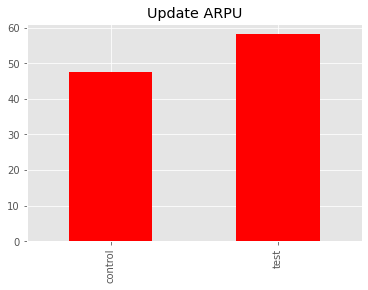

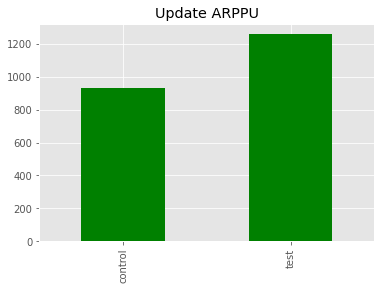

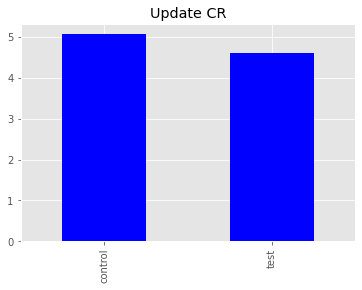

In [41]:
update_graph(update_metric)